In [1]:
import scanpy as sc
import pandas as pd
import numpy as np
import seaborn as sns
import scvi
import math
import matplotlib.pyplot as plt
import scipy.sparse
from glob import glob
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression

%matplotlib inline

Global seed set to 0


In [2]:
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')

scanpy==1.9.1 anndata==0.8.0 umap==0.5.2 numpy==1.21.6 scipy==1.9.0 pandas==1.4.3 scikit-learn==1.0.2 statsmodels==0.13.2 python-igraph==0.9.9 pynndescent==0.5.6


In [3]:
adata = sc.read_h5ad("/project2/gilad/jpopp/ebQTL/data/single_cell_objects/highpass/cellid_annotated.h5ad")

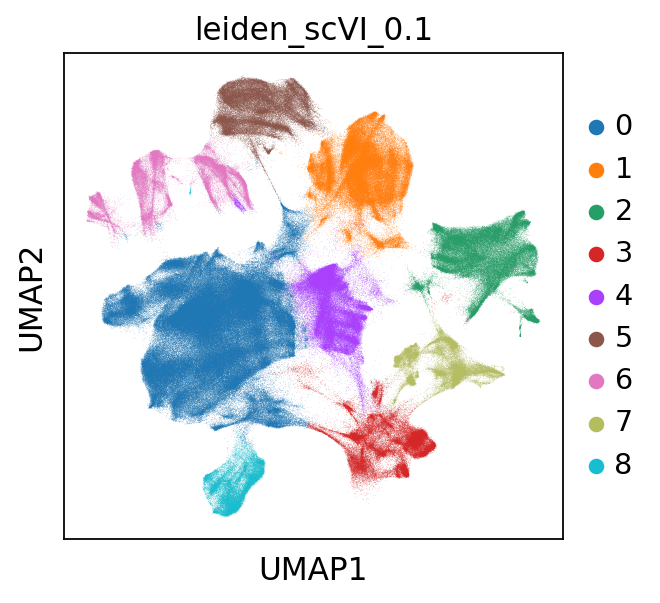

In [4]:
sc.pl.umap(adata, color=["leiden_scVI_0.1"])

In [5]:
ipsc = adata[adata.obs['leiden_scVI_0.1']=='3']
ipsc

View of AnnData object with n_obs × n_vars = 54241 × 5000
    obs: 'sample_id', 'Collection.Date', 'Lane', 'Sample.ID', 'cDNA.amp.cycles', 'cDNA.total.yield', 'library.prep.batch', 'Sequencing.batch', 'col.group', 'donor_id_x', 'prob_max', 'prob_doublet', 'n_vars', 'best_singlet', 'best_doublet', 'doublet_logLikRatio', 'Line.True', 'Line.StockLabel', 'contaminated', 'swapped', 'Feeder.passage', 'Feeder.Free.passage', 'sex', 'Formation.replicate', 'collection.replicate', 'formation.date', 'visual.confluence', 'total.cells.per.lane..correct.', 'X..Viable..based.on.average.of.two.counts.', 'days.maintained.in.LD.prior.to.formation', 'who.dissociated.the.lines.for.formation', 'cell.counter.correction', 'comments', 'collection.date', 'collection.group.label', 'EB.appearance.notes', 'dissociated.by.', 'approx..time.in.accumax..in.minutes.', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', '_scvi_batch', '_scvi_labels', '_scvi_local_l_mean', '_scvi_local_l_var', 'Z_0',

## Filter Samples

How many cells do we have for each individual in each cell type?

In [6]:
cell_counts = ipsc.obs[['donor_id_x']]
cell_counts = pd.DataFrame(cell_counts.value_counts()).reset_index(inplace=False).rename(columns={0: "n_cells_unfiltered"})
cell_counts

,donor_id_x,n_cells_unfiltered
0,NA18907,9007
1,NA19153,7394
2,NA19144,5844
3,NA19127,4652
4,NA18913,3136
5,NA19210,2735
6,NA18511,2321
7,NA18486,2235
8,NA19193,1626
9,NA18862,1592


To get this into proper form, we need to:
- Reformat cell types

In [7]:
cell_counts['type'] = "IPSC"
cell_counts['individual'] = [s.replace("NA", "") for s in cell_counts['donor_id_x']]
cell_counts['ind_type'] = cell_counts['individual'].astype(str) + "_" + cell_counts['type'].astype(str)
cell_counts = cell_counts[['ind_type', 'individual', 'type', 'n_cells_unfiltered']]
cell_counts

,ind_type,individual,type,n_cells_unfiltered
0,18907_IPSC,18907,IPSC,9007
1,19153_IPSC,19153,IPSC,7394
2,19144_IPSC,19144,IPSC,5844
3,19127_IPSC,19127,IPSC,4652
4,18913_IPSC,18913,IPSC,3136
5,19210_IPSC,19210,IPSC,2735
6,18511_IPSC,18511,IPSC,2321
7,18486_IPSC,18486,IPSC,2235
8,19193_IPSC,19193,IPSC,1626
9,18862_IPSC,18862,IPSC,1592


We'll drop any samples with less than 5 cells

In [8]:
cell_counts['dropped'] = cell_counts['n_cells_unfiltered'] < 5

## Filter Cell Types

We will filter to samples with at least 5 cells, and cell types with over 25 individuals represented.

In [9]:
ind_counts = cell_counts[cell_counts['n_cells_unfiltered'] >= 5]
ind_counts = pd.DataFrame(ind_counts[['type']].value_counts()).reset_index(inplace=False).rename(columns={0: "n_unfiltered"})
ind_counts = ind_counts[ind_counts['n_unfiltered']>25]
ind_counts

,type,n_unfiltered
0,IPSC,48


In [10]:
ind_counts.to_csv("/project2/gilad/jpopp/ebQTL/data/benchmark_static_qtl_calling/ebqtl_ipscnofilt/pseudobulk_scran/samples_per_celltype.tsv",
                  sep="\t", index=False)
ind_counts.to_csv("/project2/gilad/jpopp/ebQTL/data/benchmark_static_qtl_calling/ebqtl_ipscnofilt/pseudobulk_tmm/samples_per_celltype.tsv",
                  sep="\t", index=False)

## Load Raw Data

First, we can highlight which samples will be kept for QTL analysis

In [11]:
cell_types_inc = ind_counts['type']
samples_inc = cell_counts[(cell_counts['dropped'] == False) & (cell_counts['type'].isin(cell_types_inc))]['ind_type']

In [12]:
cell_subset = ipsc.obs[['donor_id_x']]
cell_subset['type'] = "IPSC"
cell_subset['ind'] = [s.replace("NA", "") for s in cell_subset['donor_id_x'].astype(str)]
cell_subset['sample'] = cell_subset['ind'] + "_" + cell_subset['type']
cell_subset = cell_subset[cell_subset['sample'].isin(samples_inc)]
cell_subset

/tmp/jobs/25724822/ipykernel_310383/3416183574.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cell_subset['type'] = "IPSC"
/tmp/jobs/25724822/ipykernel_310383/3416183574.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cell_subset['ind'] = [s.replace("NA", "") for s in cell_subset['donor_id_x'].astype(str)]
/tmp/jobs/25724822/ipykernel_310383/3416183574.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value in

,donor_id_x,type,ind,sample
cell,,,,
TCGTGGGTCCGCTGTT-91,NA18486,IPSC,18486,18486_IPSC
TGTTCATAGCGTCTCG-21,NA18907,IPSC,18907,18907_IPSC
AGCTTCCGTTGTTGAC-50,NA18855,IPSC,18855,18855_IPSC
AAGAACATCAAGGCTT-40,NA19093,IPSC,19093,19093_IPSC
GCAACATCAGAAGCGT-31,NA19153,IPSC,19153,19153_IPSC
...,...,...,...,...
TGGTTAGAGGTGCATG-81,NA19127,IPSC,19127,19127_IPSC
AATTTCCAGGACAGCT-49,NA18507,IPSC,18507,18507_IPSC
GCTTGGGTCAAGTAAG-45,NA19098,IPSC,19098,19098_IPSC


For pseudobulk aggregation, we're going to use the scran-normalized data

In [13]:
scran_adata = sc.read_h5ad("/project2/gilad/ktayeb/ebqtl-workflowr/output/proc/EB_high_pass_filtered_normalized.h5ad")

In [14]:
scran_adata = scran_adata[cell_subset.index]

In [15]:
scran_adata.layers['data'] = scran_adata.X

Remove parts of this anndata object that are no longer necessary

In [16]:
del scran_adata.uns
del scran_adata.obsm
del scran_adata.varm
del scran_adata.obsp

Get raw counts from the scran-normalized data

In [17]:
adj_counts = scipy.sparse.csr_matrix.expm1(scran_adata.X)
size_factors = np.array(scran_adata.obs['sizeFactor'])
raw_counts = np.rint(adj_counts.transpose().multiply(size_factors).toarray()).transpose()
scran_adata.layers['counts'] = raw_counts
scran_adata.X = raw_counts

## Filter Cells

### IPSC

In [18]:
scran_adata.var['mt'] = scran_adata.var_names.str.startswith('MT-')
sc.pp.calculate_qc_metrics(scran_adata, qc_vars=['mt'], inplace=True)

#### Metrics related to cell depth

Text(0.5, 1.0, 'N Genes By Counts')

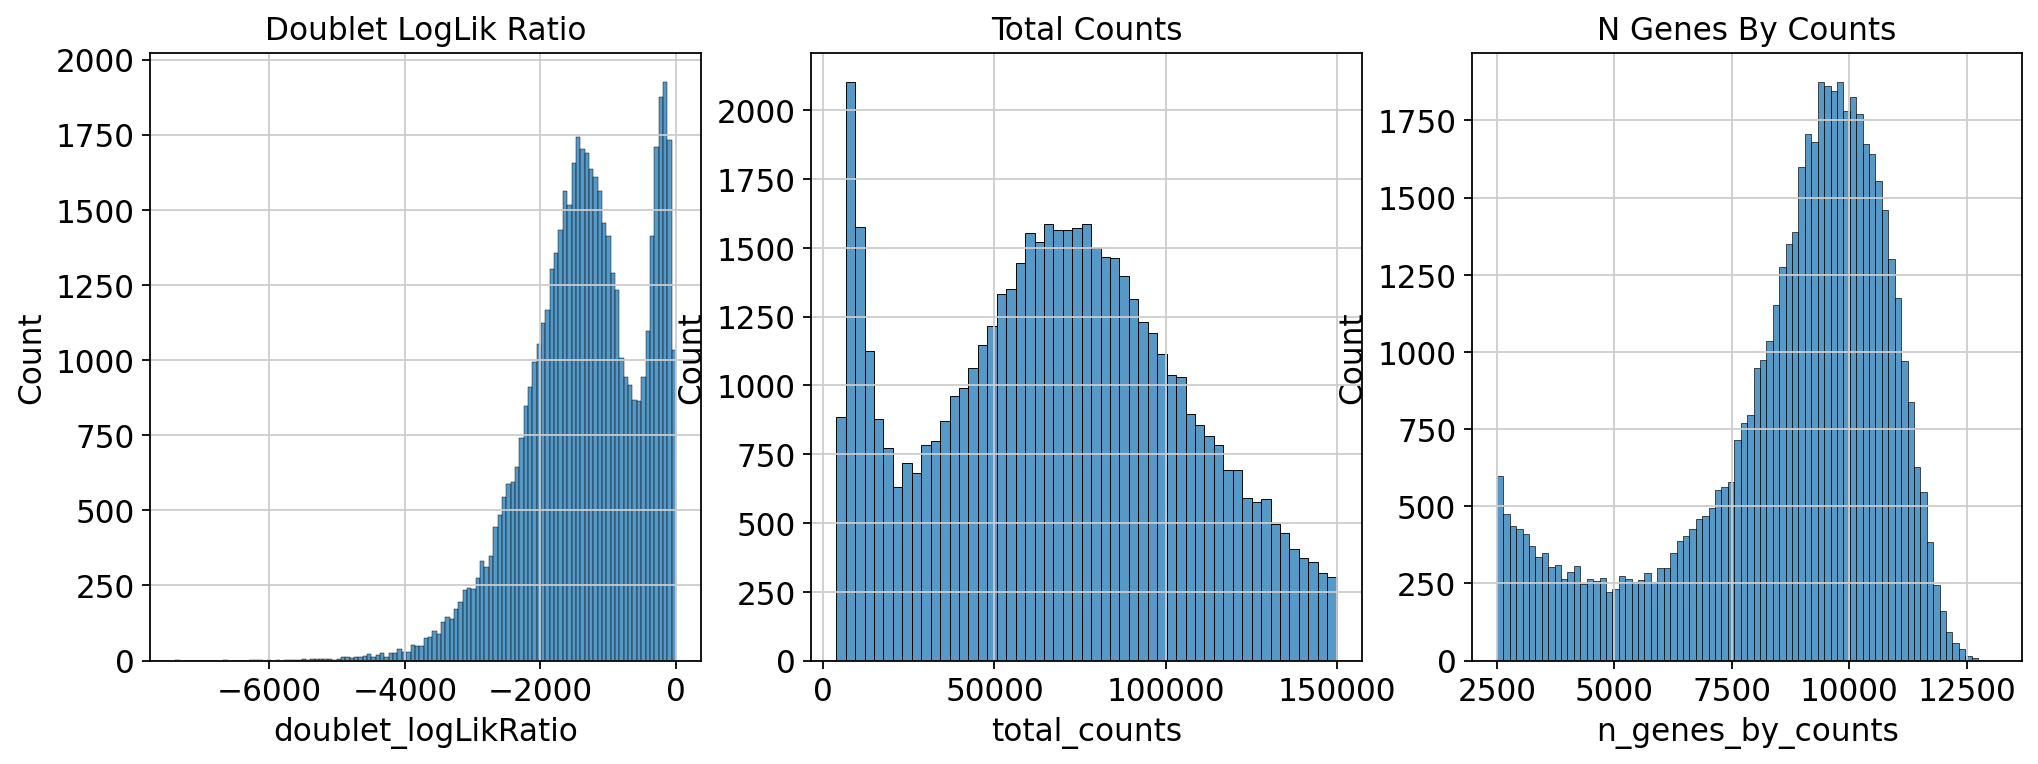

In [19]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=False)

sns.histplot(ax=axes[0], x=scran_adata.obs['doublet_logLikRatio'])
axes[0].set_title('Doublet LogLik Ratio')

sns.histplot(ax=axes[1], x=scran_adata.obs['total_counts'])
axes[1].set_title('Total Counts')

sns.histplot(ax=axes[2], x=scran_adata.obs['n_genes_by_counts'])
axes[2].set_title('N Genes By Counts')

#### Metrics related to mitochondrial reads

<AxesSubplot:xlabel='pct_counts_mt', ylabel='Count'>

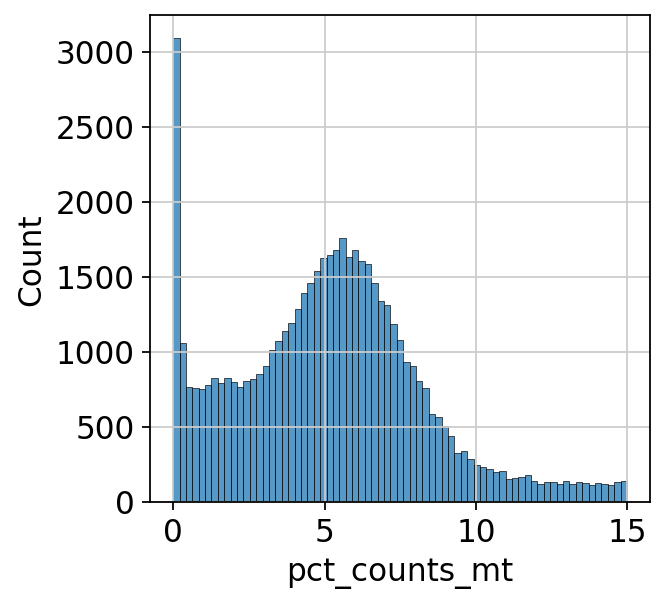

In [20]:
sns.histplot(scran_adata.obs['pct_counts_mt'])

#### Metrics related to expression patterns

In [21]:
sc.pp.highly_variable_genes(scran_adata, layer='counts', n_top_genes=1000, flavor='seurat_v3', subset=False)
scran_adata.X = scran_adata.layers['data']
sc.pp.scale(scran_adata)
scran_adata.layers['scaled'] = scran_adata.X

If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'variances_norm', float vector (adata.var)
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


In [22]:
pluripotency_genes = ['POU5F1', 'NANOG', 'GAL', 'UTF1', 'GDF3', 
                      'FGF4', 'LIN28A', 'TFCP2L1', 'DNMT3B', 
                      'NODAL', 'TDGF1', 'TRF1', 'DPPA3', 'DPPA5']
sc.tl.score_genes(scran_adata, gene_list=pluripotency_genes, score_name='pluripotency_score')

computing score 'pluripotency_score'


/scratch/midway2/jpopp/.conda/envs/scvi-scanpy/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):


    finished: added
    'pluripotency_score', score of gene set (adata.obs).
    499 total control genes are used. (0:00:10)


<AxesSubplot:xlabel='pluripotency_score', ylabel='Count'>

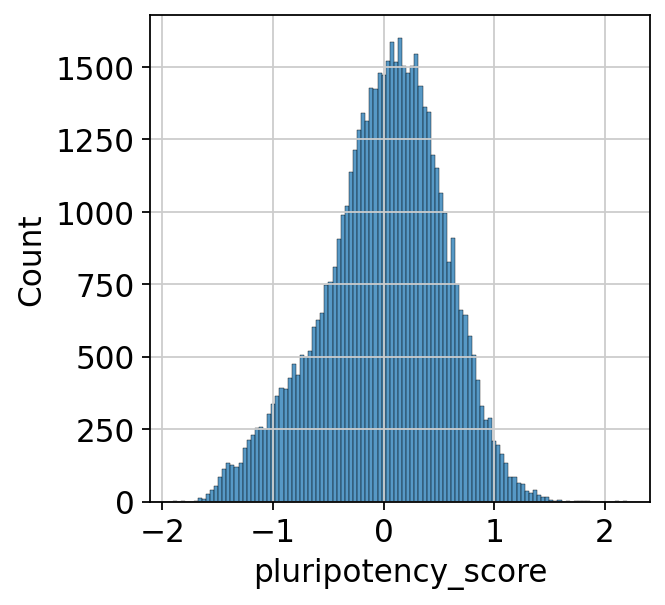

In [23]:
sns.histplot(scran_adata.obs['pluripotency_score'])

In [24]:
cell_cycle_genes = [x.strip() for x in open('/project2/gilad/jpopp/ebQTL/data/gene_sets/regev_lab_cell_cycle_genes.txt')]

In [25]:
s_genes = cell_cycle_genes[:43]
g2m_genes = cell_cycle_genes[43:]
cell_cycle_genes = [x for x in cell_cycle_genes if x in adata.var_names]

In [26]:
sc.tl.score_genes_cell_cycle(scran_adata, s_genes=s_genes, g2m_genes=g2m_genes)

calculating cell cycle phase
computing score 'S_score'


/scratch/midway2/jpopp/.conda/envs/scvi-scanpy/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):


    finished: added
    'S_score', score of gene set (adata.obs).
    685 total control genes are used. (0:00:10)
computing score 'G2M_score'


/scratch/midway2/jpopp/.conda/envs/scvi-scanpy/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):


    finished: added
    'G2M_score', score of gene set (adata.obs).
    687 total control genes are used. (0:00:10)
-->     'phase', cell cycle phase (adata.obs)


Text(0.5, 1.0, 'G2M Score')

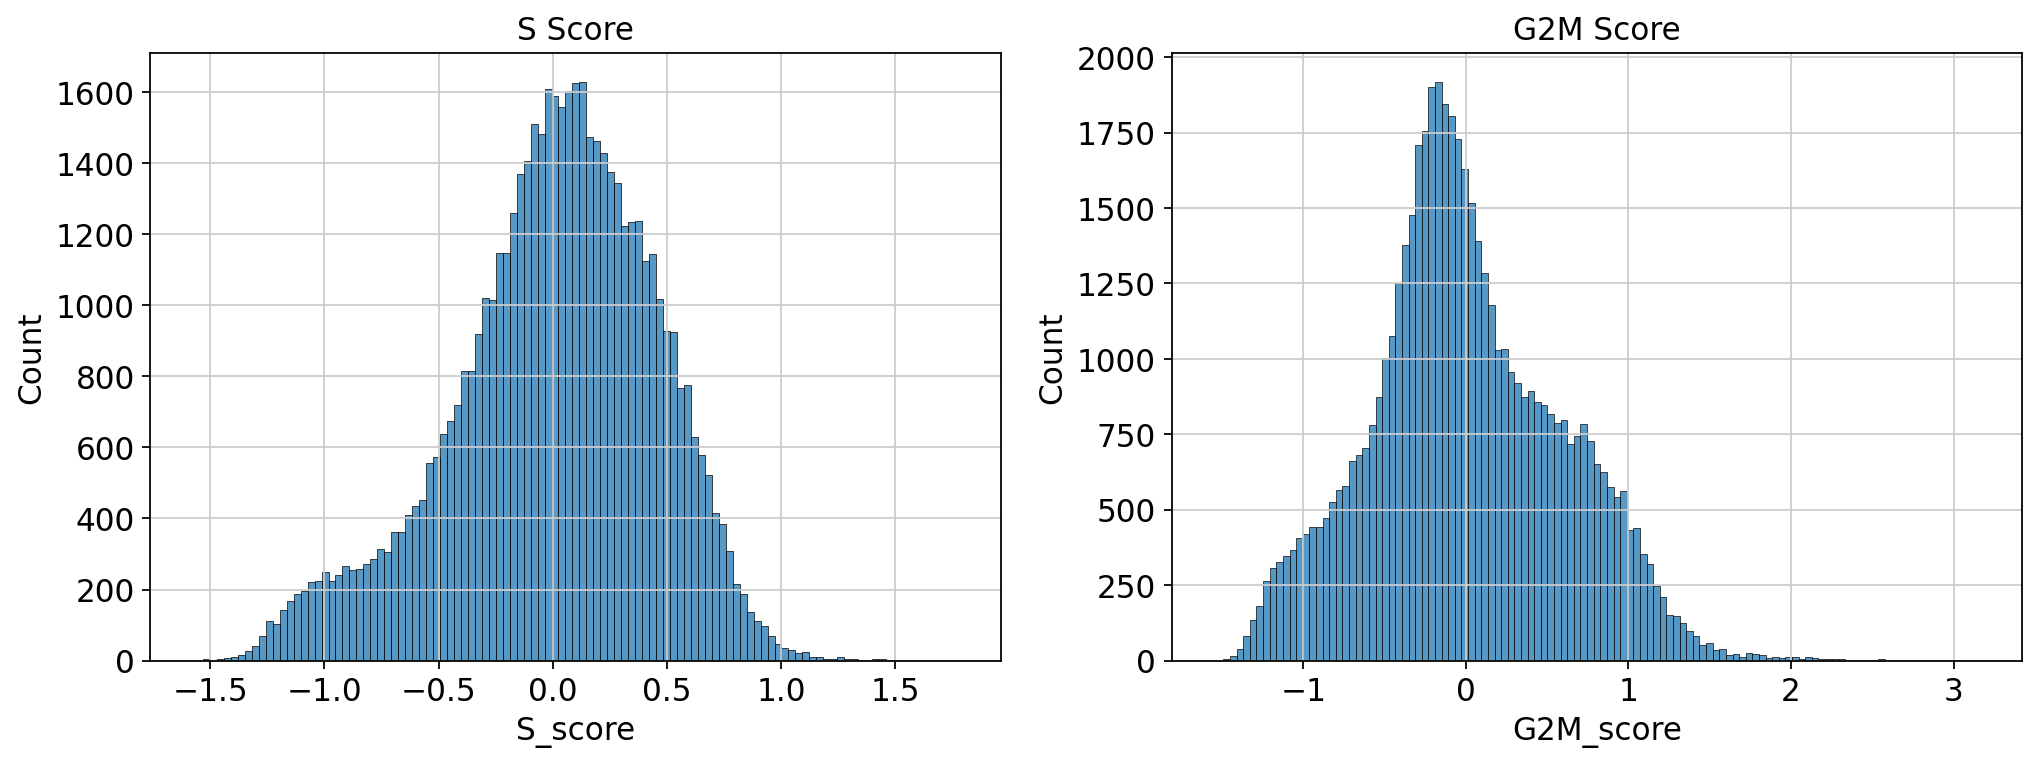

In [27]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5), sharey=False)

sns.histplot(ax=axes[0], x=scran_adata.obs['S_score'])
axes[0].set_title('S Score')

sns.histplot(ax=axes[1], x=scran_adata.obs['G2M_score'])
axes[1].set_title('G2M Score')

#### Exploring expression variation

In [28]:
sc.pp.pca(scran_adata)

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:09)


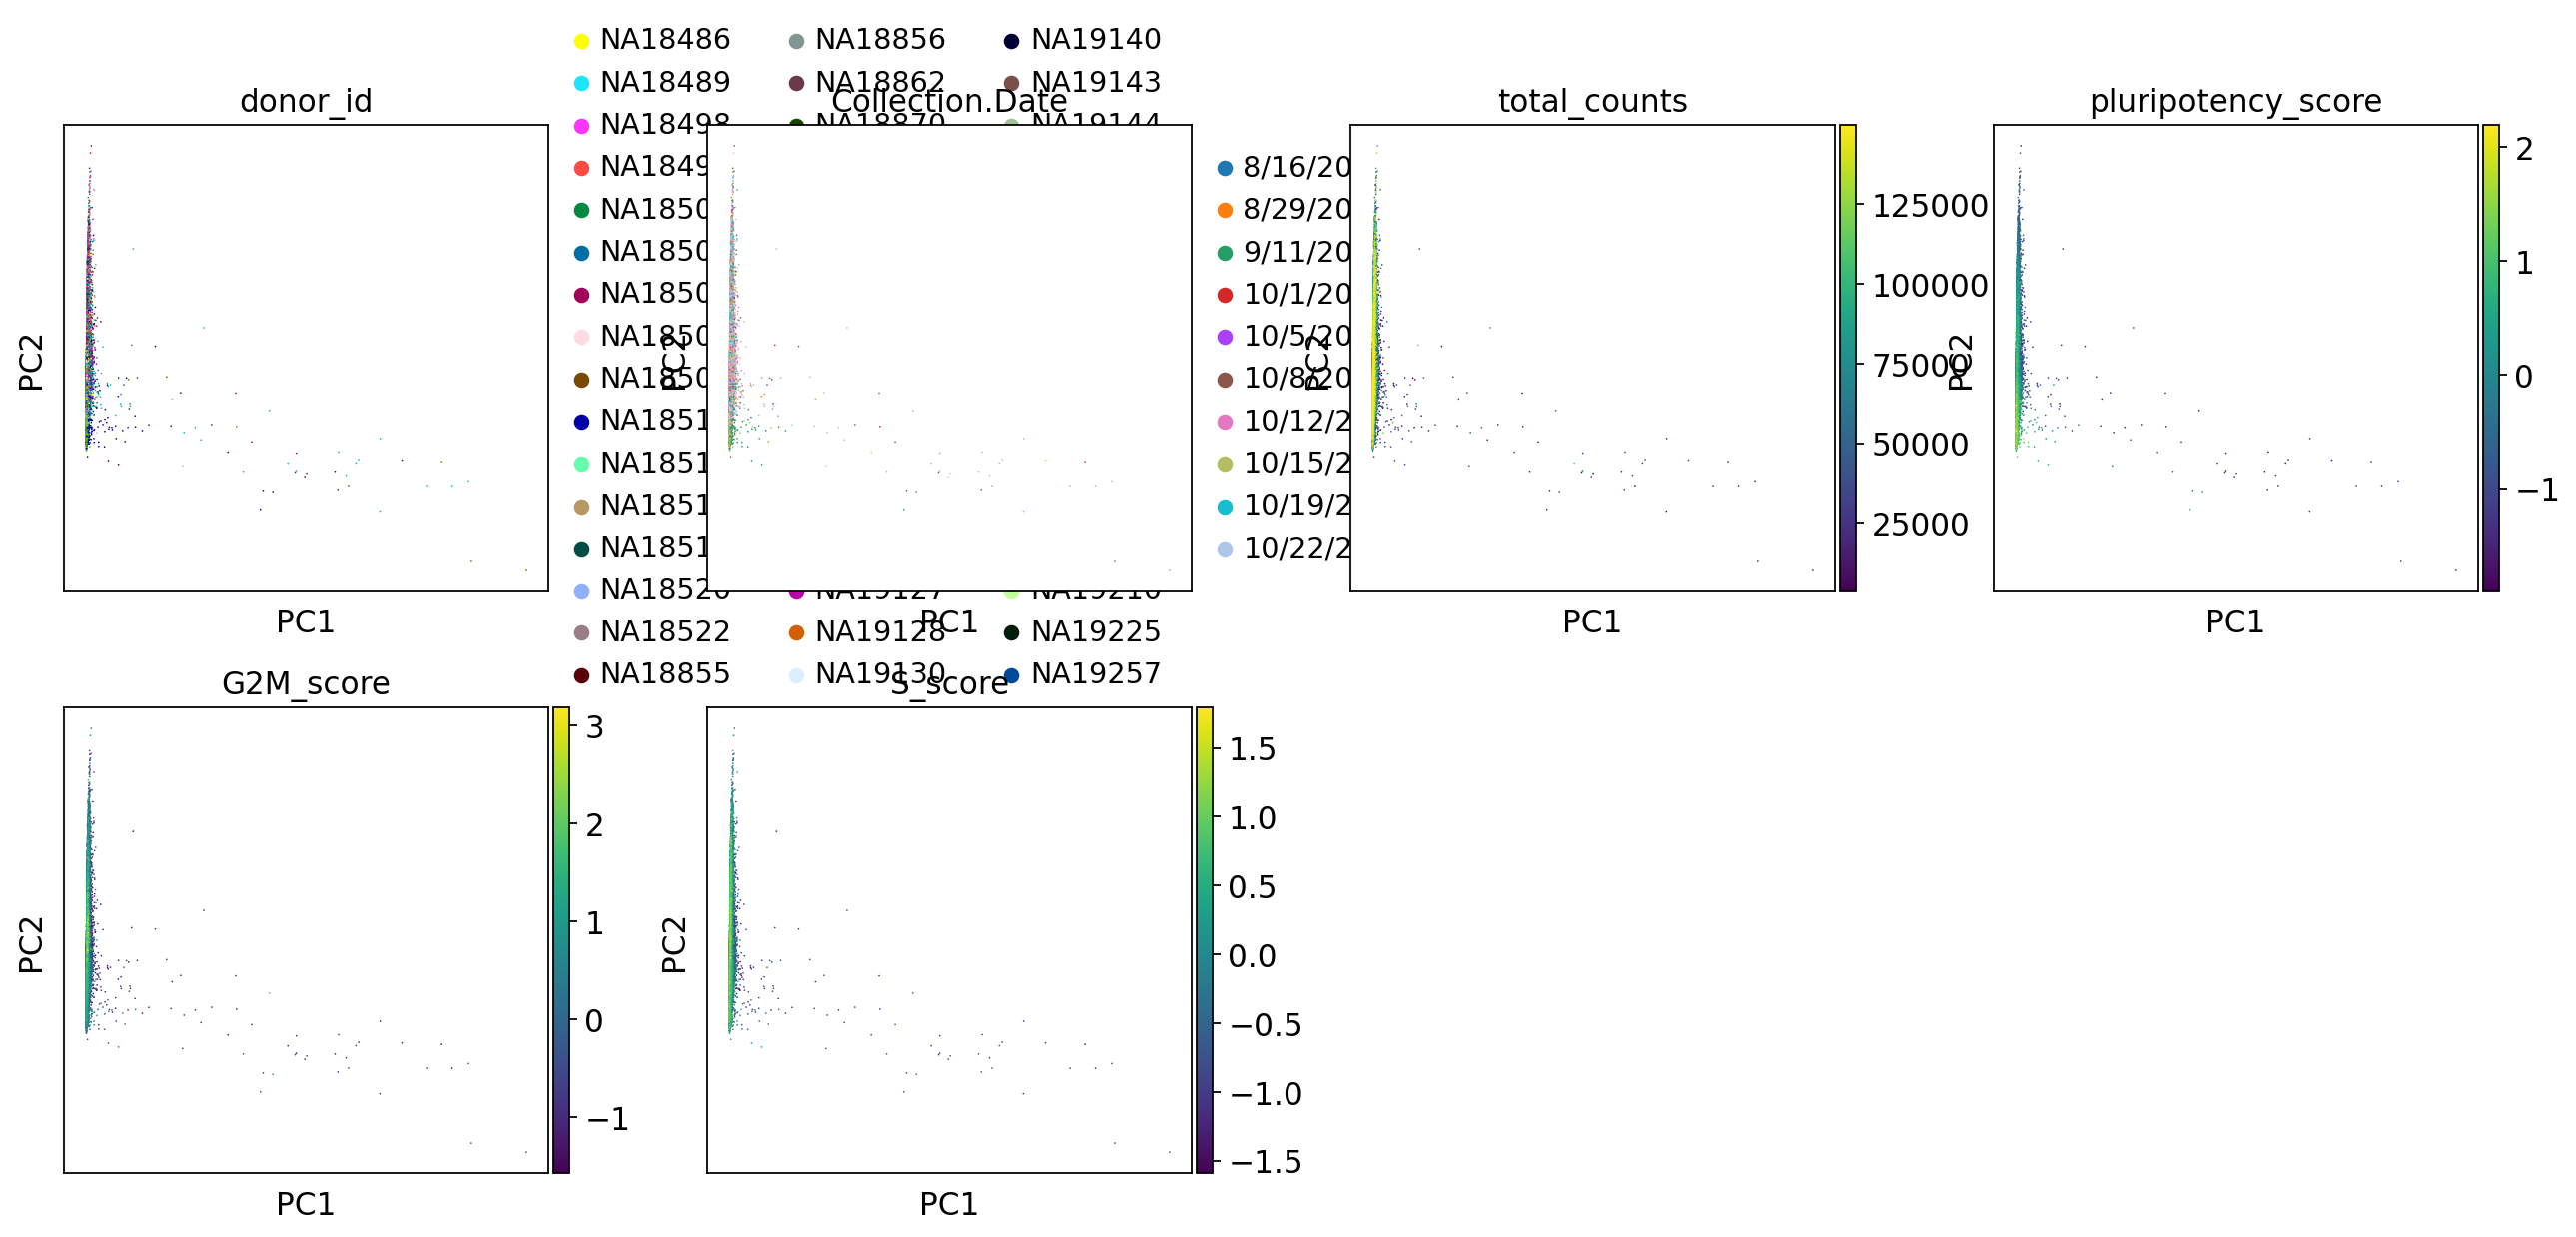

In [29]:
sc.pl.pca(scran_adata, color=['donor_id', 'Collection.Date', 'total_counts', 'pluripotency_score', 'G2M_score', 'S_score'])

In [30]:
covariates = ['donor_id', 'Collection.Date', 'total_counts', 'pluripotency_score', 'G2M_score', 'S_score']

In [31]:
mat = np.zeros([len(covariates), 10])

In [32]:
for k in range(len(covariates)):
    if scran_adata.obs[covariates[k]].dtype.name == 'category':
        X_pd = scran_adata.obs[[covariates[k]]]
        X_pd['intercept'] = 1
        X = OneHotEncoder().fit(X_pd).transform(X_pd)
    else:
        X_pd = scran_adata.obs[[covariates[k]]]
        X_pd['intercept'] = 1
        X = X_pd.to_numpy()
    for pc in range(len(covariates)):
        y = scran_adata.obsm['X_pca'][:, pc]
        r2 = LinearRegression().fit(X, y).score(X, y)
        mat[k, pc] = r2

/tmp/jobs/25724822/ipykernel_310383/515339297.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_pd['intercept'] = 1
/tmp/jobs/25724822/ipykernel_310383/515339297.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_pd['intercept'] = 1
/tmp/jobs/25724822/ipykernel_310383/515339297.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-

(array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5]),
 [Text(0, 0.5, 'donor_id'),
  Text(0, 1.5, 'Collection.Date'),
  Text(0, 2.5, 'total_counts'),
  Text(0, 3.5, 'pluripotency_score'),
  Text(0, 4.5, 'G2M_score'),
  Text(0, 5.5, 'S_score')])

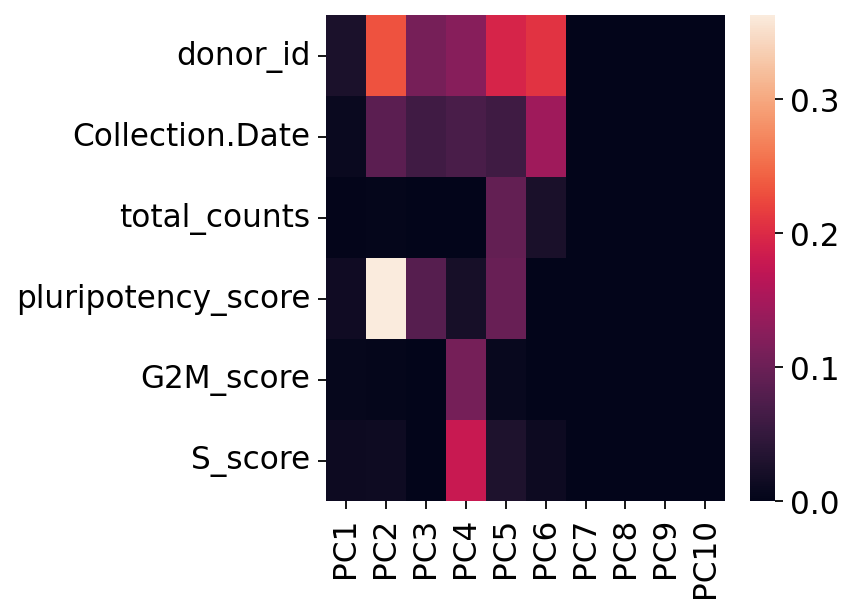

In [33]:
sns.heatmap(mat,
            xticklabels=['PC' + str(i) for i in range(1, 11)],
            yticklabels=covariates)
plt.yticks(rotation=0)

In [34]:
scran_adata.write_h5ad("/project2/gilad/jpopp/ebQTL/data/benchmark_static_qtl_calling/ebqtl_ipscnofilt/ebqtl_ipscnofilt.h5ad")

In [35]:
#ipsc_filt = sc.read_h5ad("/project2/gilad/jpopp/ebQTL/data/single_cell_objects/highpass/ebqtl_ipsc.h5ad")

#### Update summary tables

In [35]:
filtered_counts = scran_adata.obs[['donor_id', 'total_counts', 'pluripotency_score']]
filtered_counts['n_cells_filtered'] = 1
filtered_counts = filtered_counts.groupby('donor_id').agg({'total_counts': 'sum', 'n_cells_filtered': 'count', 'pluripotency_score': 'median'})
filtered_counts = filtered_counts.reset_index().astype({'total_counts': 'int'})
filtered_counts['individual'] = [s.replace("NA", "") for s in filtered_counts['donor_id']]
filtered_counts = filtered_counts.drop(columns='donor_id')
filtered_counts

/tmp/jobs/25724822/ipykernel_310383/2997675211.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_counts['n_cells_filtered'] = 1


,total_counts,n_cells_filtered,pluripotency_score,individual
0,140155775,2235,-0.179108,18486
1,16304691,310,-0.377412,18489
2,11774043,172,-0.280597,18498
3,4290787,134,-0.904398,18499
4,5101883,79,-0.079981,18501
5,19267323,263,-0.330864,18502
6,5669405,115,-0.424244,18505
7,37675987,583,-0.205679,18507
8,5597749,108,-0.450297,18508
9,90912829,2321,0.506224,18511


In [36]:
cell_counts_filtered = cell_counts.merge(filtered_counts, on='individual', how='left').fillna(0).astype({'total_counts': 'int', 'n_cells_filtered': 'int'})
cell_counts_filtered['dropped'] = cell_counts_filtered['n_cells_filtered'] < 5
cell_counts_filtered = cell_counts_filtered.sort_values(by="n_cells_filtered", ascending=False)

In [45]:
cell_counts_filtered.to_csv("/project2/gilad/jpopp/ebQTL/data/benchmark_static_qtl_calling/ebqtl_ipscnofilt/pseudobulk_scran/sample_summary.tsv", sep="\t")
cell_counts_filtered.to_csv("/project2/gilad/jpopp/ebQTL/data/benchmark_static_qtl_calling/ebqtl_ipscnofilt/pseudobulk_tmm/sample_summary.tsv", sep="\t")

In [39]:
#cell_counts_filtered = pd.read_csv("/project2/gilad/jpopp/ebQTL/data/static/ebqtl_ipsc/pseudobulk-scran/sample_summary_filtered.tsv", sep="\t")

## Aggregation

### Aggregate raw counts

In [38]:
cell_subset = scran_adata.obs[['donor_id']]
cell_subset['type'] = "IPSC"
cell_subset['ind'] = [s.replace("NA", "") for s in cell_subset['donor_id'].astype(str)]
cell_subset['sample'] = cell_subset['ind'] + "_" + cell_subset['type']
onehot = OneHotEncoder(sparse=True).fit_transform(cell_subset[['sample']])
onehot

/tmp/jobs/25724822/ipykernel_310383/3842614451.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cell_subset['type'] = "IPSC"
/tmp/jobs/25724822/ipykernel_310383/3842614451.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cell_subset['ind'] = [s.replace("NA", "") for s in cell_subset['donor_id'].astype(str)]
/tmp/jobs/25724822/ipykernel_310383/3842614451.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value inst

<54236x48 sparse matrix of type '<class 'numpy.float64'>'
	with 54236 stored elements in Compressed Sparse Row format>

In [39]:
pseudobulk_sum = scran_adata.layers['counts'].transpose() * onehot

In [40]:
pseudobulk_sum = pd.DataFrame(pseudobulk_sum, index=scran_adata.var_names, columns=cell_subset['sample'].astype("category").cat.categories)

In [41]:
pseudobulk_sum.to_csv("/project2/gilad/jpopp/ebQTL/data/benchmark_static_qtl_calling/ebqtl_ipscnofilt/pseudobulk_tmm/ebqtl_ipscnofilt.pseudobulk_tmm.tsv",
                       sep="\t", index_label="gene")

### Aggregate scran-normalized counts

In [42]:
n_cells = onehot.sum(axis=0)
pseudobulk_sum_norm = scran_adata.layers['data'].transpose() * onehot
pseudobulk_mean_norm = pseudobulk_sum_norm / n_cells

In [43]:
pseudobulk_mean_norm = pd.DataFrame(pseudobulk_mean_norm, 
                                    index=scran_adata.var_names, columns=cell_subset['sample'].astype("category").cat.categories)

In [44]:
pseudobulk_mean_norm.to_csv("/project2/gilad/jpopp/ebQTL/data/benchmark_static_qtl_calling/ebqtl_ipscnofilt/pseudobulk_scran/ebqtl_ipscnofilt.pseudobulk_scran.tsv",
                       sep="\t", index_label="gene")